In [1]:
# importing useful libraries
import numpy as np
import tensorflow as tf
import random as python_random

# setting random seed for result reproducibility
np.random.seed(1)
python_random.seed(12)
tf.random.set_seed(123)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import fbeta_score

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
mnist = tf.keras.datasets.mnist # downloading the dataset

# unpacking the training and testing set
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print('Training features have shape: {}, while labels have shape{}'.format(train_images.shape, train_labels.shape))
print('Testing features have shape: {}, while labels have shape{}'.format(test_images.shape, test_labels.shape))

class_labels = np.unique(train_labels)
print("There are {} classes in the dataset. They are {}".format(len(class_labels), class_labels))

Training features have shape: (60000, 28, 28), while labels have shape(60000,)
Testing features have shape: (10000, 28, 28), while labels have shape(10000,)
There are 10 classes in the dataset. They are [0 1 2 3 4 5 6 7 8 9]


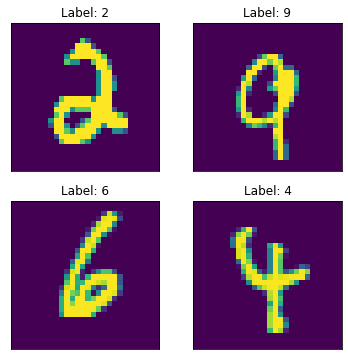

In [3]:
fig = plt.figure(figsize=(6, 6))
random_labels = np.random.choice(class_labels, size=4, replace=False)
for ind in range(len(random_labels)):
  random_ind = np.random.choice([i for i in range(len(train_labels)) if train_labels[i] == random_labels[ind]])
  ax = fig.add_subplot(2, 2, ind+1)
  plt.imshow(train_images[random_ind])
  plt.title("Label: {}".format(train_labels[random_ind]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)
plt.show()

In [4]:
# re-scaling the data
train_images = train_images / 255
test_images = test_images / 255

multi_class_train_labels = to_categorical(train_labels, 10) # does one hot encoding
multi_class_test_labels = to_categorical(test_labels, 10) # does one hot encoding


In [5]:
def multi_class_eager_fbeta(ytrue, ypred, beta=1.0, weighted=False):
  ypred = np.array(np.equal(ypred, np.max(ypred, axis=-1).reshape(-1, 1)), dtype=np.float32)
  if weighted:
    average = 'weighted'
  else:
    average = 'macro'
    
  return fbeta_score(ytrue, ypred, beta, average=average)

In [6]:
def multi_class_fbeta(ytrue , ypred, beta=1, average='macro', epsilon=1e-7):
    # epsilon is set to avoid division by zero error
    beta_squared = beta**2

    # casting ytrue and ypred as floats
    ytrue = tf.cast(ytrue, tf.float32)
    ypred= tf.cast(ypred, tf.float32)
    
    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    tp = tf.reduce_sum(ytrue*ypred, axis=0) # calculating true positives
    predicted_positive = tf.reduce_sum(ypred, axis=0) # calculating predicted positives
    actual_positive = tf.reduce_sum(ytrue, axis=0) # calculating actual positives
    
    # calculating precision and recall
    precision = tp/(predicted_positive+epsilon)
    recall = tp/(actual_positive+epsilon)

    # finding fbeta
    fb = (1+beta_squared)*precision*recall / (beta_squared*precision + recall + epsilon)

    if average == 'weighted':
      supports = tf.reduce_sum(ytrue, axis=0)
      return tf.reduce_sum(fb*supports / tf.reduce_sum(supports))

    elif average == 'raw':
      return fb

    return tf.reduce_mean(fb)

In [7]:
def build_model(start=512, metrics=multi_class_fbeta, run_eagerly=False, lr=1e-3):
    model = Sequential() # initializes a sequential model

    # adding three layers where a filter size is half of the preceding filter size
    for _ in range(3):
      model.add(Conv2D(filters=512, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
      start //= 2

    model.add(Flatten()) # flattens the layer

    model.add(Dense(10, activation='softmax')) # ouput layer

    opt = Adam(lr=lr) # initializes an optimizer

    # compling model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[metrics], run_eagerly=run_eagerly)
    
    return model

In [8]:
eager_multi_class_model = build_model(metrics=multi_class_eager_fbeta, run_eagerly=True)
eager_multi_class_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=multi_class_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 90s 255ms/step - loss: 0.1533 - multi_class_eager_fbeta: 0.9517 - val_loss: 0.1044 - val_multi_class_eager_fbeta: 0.9691
Epoch 2/3
352/352 [==============================] - 89s 254ms/step - loss: 0.0471 - multi_class_eager_fbeta: 0.9853 - val_loss: 0.0569 - val_multi_class_eager_fbeta: 0.9830
Epoch 3/3
352/352 [==============================] - 90s 256ms/step - loss: 0.0312 - multi_class_eager_fbeta: 0.9901 - val_loss: 0.0821 - val_multi_class_eager_fbeta: 0.9764


In [9]:
multi_class_model = build_model()
multi_class_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=multi_class_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 68s 194ms/step - loss: 0.1530 - multi_class_fbeta: 0.9529 - val_loss: 0.1142 - val_multi_class_fbeta: 0.9664
Epoch 2/3
352/352 [==============================] - 68s 192ms/step - loss: 0.0474 - multi_class_fbeta: 0.9849 - val_loss: 0.0598 - val_multi_class_fbeta: 0.9820
Epoch 3/3
352/352 [==============================] - 68s 192ms/step - loss: 0.0312 - multi_class_fbeta: 0.9903 - val_loss: 0.0673 - val_multi_class_fbeta: 0.9821


In [10]:
# predictings the testing set
multi_class_ypred = multi_class_model.predict(test_images.reshape(-1, 28, 28, 1))

# one_hot encoding predictions 
multi_class_ypred = np.array(np.equal(multi_class_ypred, np.max(multi_class_ypred, axis=-1).reshape(-1, 1)), dtype=np.float32)

print('Shape of testing labels is {}'.format(multi_class_ypred.shape))
print('Shape of predicted testing labels is {}'.format(multi_class_test_labels.shape))
print()
print('f1_score of prediction using multi_class_fbeta is {}'.format(multi_class_fbeta(multi_class_test_labels, multi_class_ypred)))
print('f1_score of prediction using scikit-learn fbeta is {}'.format(fbeta_score(multi_class_test_labels, multi_class_ypred, beta=1, average='macro')))
print()
print('weighted f1_score of prediction using multi_class_fbeta is {}'.format(multi_class_fbeta(multi_class_test_labels, multi_class_ypred, average='weighted')))
print('weighted f1_score of prediction using scikit-learn fbeta is {}'.format(fbeta_score(multi_class_test_labels, multi_class_ypred, beta=1, average='weighted')))
print()
print('raw fbeta scores for each class are {}'.format(multi_class_fbeta(multi_class_test_labels, multi_class_ypred, average='raw').numpy()))

Shape of testing labels is (10000, 10)
Shape of predicted testing labels is (10000, 10)

f1_score of prediction using multi_class_fbeta is 0.9861151576042175
f1_score of prediction using scikit-learn fbeta is 0.986115259340232

weighted f1_score of prediction using multi_class_fbeta is 0.9861977696418762
weighted f1_score of prediction using scikit-learn fbeta is 0.9861978437799129

raw fbeta scores for each class are [0.99183667 0.9911971  0.98290175 0.98458475 0.9878665  0.98096293
 0.9889879  0.98446596 0.9847094  0.983639  ]


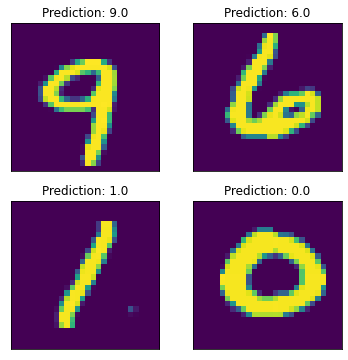

In [11]:
# converting one hot encoded predictions to integers
multi_class_ypred2 = (np.array([[i for i in range(10)] for _ in range(multi_class_ypred.shape[0])]) * multi_class_ypred).sum(axis=-1)

fig = plt.figure(figsize=(6, 6))
random_labels = np.random.choice(class_labels, size=4, replace=False)

for ind in range(len(random_labels)):
  random_ind = np.random.choice([i for i in range(len(test_labels)) if test_labels[i] == random_labels[ind]])
  ax = fig.add_subplot(2, 2, ind+1)
  plt.imshow(test_images[random_ind])
  plt.title("Prediction: {}".format(multi_class_ypred2[random_ind]))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

plt.show()

In [12]:
class StatefullMultiClassFBeta(Metric):
  def __init__(self, name='state_full_binary_fbeta', beta=1, n_class=10, average='macro', epsilon=1e-7, **kwargs):
    # initializing an object of the super class
    super(StatefullMultiClassFBeta, self).__init__(name=name, **kwargs)

    # initializing atrributes
    self.tp = self.add_weight(name='tp', shape=(n_class,), initializer='zeros')     # initializing true positives
    self.actual_positives = self.add_weight(name='ap', shape=(n_class,), initializer='zeros') # initializing actual positives
    self.predicted_positives = self.add_weight(name='pp', shape=(n_class,), initializer='zeros') # initializing predicted positives

    # initializing other atrributes that wouldn't be changed for every object of this class
    self.beta_squared = beta**2
    self.n_class = n_class
    self.average = average
    self.epsilon = epsilon

  def update_state(self, ytrue, ypred, sample_weight=None):
    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)
        
    self.tp.assign_add(tf.reduce_sum(ytrue*ypred, axis=0)) # updating true positives atrribute
    self.predicted_positives.assign_add(tf.reduce_sum(ypred, axis=0)) # updating predicted positives atrribute
    self.actual_positives.assign_add(tf.reduce_sum(ytrue, axis=0)) # updating actual positives atrribute

  def result(self):
    self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
    self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

    # calculating fbeta score
    self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

    if self.average == 'weighted':
      return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))
    
    elif self.average == 'raw':
      return self.fb

    return tf.reduce_mean(self.fb)

  def reset_states(self):
    self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
    self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
    self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

In [13]:
statefull_multi_class_fbeta = StatefullMultiClassFBeta()
statefull_multi_class_model = build_model(metrics=statefull_multi_class_fbeta)
statefull_multi_class_model.fit(x=train_images.reshape(-1, 28, 28, 1), y=multi_class_train_labels, batch_size=128, epochs=3, validation_split=0.25, shuffle=False);

Epoch 1/3
352/352 [==============================] - 68s 194ms/step - loss: 0.1523 - state_full_binary_fbeta: 0.9541 - val_loss: 0.0954 - val_state_full_binary_fbeta: 0.9727
Epoch 2/3
352/352 [==============================] - 68s 193ms/step - loss: 0.0480 - state_full_binary_fbeta: 0.9852 - val_loss: 0.0569 - val_state_full_binary_fbeta: 0.9833
Epoch 3/3
352/352 [==============================] - 68s 192ms/step - loss: 0.0313 - state_full_binary_fbeta: 0.9901 - val_loss: 0.0678 - val_state_full_binary_fbeta: 0.9807


In [14]:
# defining a function to randomly change zeros to ones
def change_to_one(row):
  row[np.random.choice(list(range(len(row))))] = 1
  return row

In [15]:
n_sample = 20
n_class = 3
m = StatefullMultiClassFBeta(n_class=n_class) # initializes a stateful multi class fbeta object
arr_true, arr_pred = np.zeros((n_sample, n_class)), np.zeros((n_sample, n_class)) # initializes true and pred to zeros

# randomly changing zeros in arr_true and arr_pred to ones
arr_true = np.apply_along_axis(change_to_one, axis=1, arr=arr_true) 
arr_pred = np.apply_along_axis(change_to_one, axis=1, arr=arr_pred)

m.update_state(arr_true, arr_pred)
print('Intermediate result for stateful multi class fbeta is: {}'.format(float(m.result())))
print('Intermediate result for scikit-learn fbeta is: {}'.format(fbeta_score(arr_true, arr_pred, beta=1, average='macro')))
print()

increment_size = 20
a_true, a_pred= np.zeros((increment_size, n_class)), np.zeros((increment_size, n_class))
a_true = np.apply_along_axis(change_to_one, axis=1, arr=a_true)
a_pred = np.apply_along_axis(change_to_one, axis=1, arr=a_pred)

m.update_state(a_true, a_pred)
print('Final result for stateful multi class fbeta is: {}'.format(float(m.result())))

arr_true = np.append(arr_true, a_true, axis=0)
arr_pred = np.append(arr_pred, a_pred, axis=0)

print('Final result for scikit-learn multi class fbeta is: {}'.format(fbeta_score(arr_true, arr_pred, beta=1, average='macro')))

Intermediate result for stateful multi class fbeta is: 0.2868777811527252
Intermediate result for scikit-learn fbeta is: 0.2868778280542987

Final result for stateful multi class fbeta is: 0.26536789536476135
Final result for scikit-learn multi class fbeta is: 0.26536796536796536
